<a href="https://www.kaggle.com/code/vladd0s/titanic-age-random-forest-model-mae-9-22?scriptVersionId=242786570" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ML Titanic Age Regressor
<p> This notebook develop regression model based on Random Forest for age prediction to fill na values for another models </p>
<p> Final  results are MAE 9.22 and model saving as .joblib</p>

<h2> Aim of this notebook </h2>
Aim of the notebook is to develop a Random Forest Regressor model to predict NA values in original Titanic dataset

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
titanic_data = pd.read_csv("../../data/train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
print("Missing values:")
titanic_data.isna().sum()

Missing values:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Data preprocessing

Some of the Passengers have a long name because of their high social status.

In [10]:
#count number of words by spaces in names
name_words_count = titanic_data.Name.apply(lambda x: x.count(" "))
titanic_data["Name"] = name_words_count

#Encoding for sex (1 - male, 0 - female)
titanic_data["Sex"]= titanic_data.Sex.apply(lambda x: x == "male")

#drop tickets number and cabins from dataset
titanic_data = titanic_data.drop(["Ticket","Cabin"], axis=1)

# EDA

Most ages are located between 20 and 38 years. This distribution can create difficulties fo model to predict ages correctly

## Distributions

In [11]:
#Ages distribution
titanic_data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Text(0.5, 1.0, 'Words in Passengers names distribution')

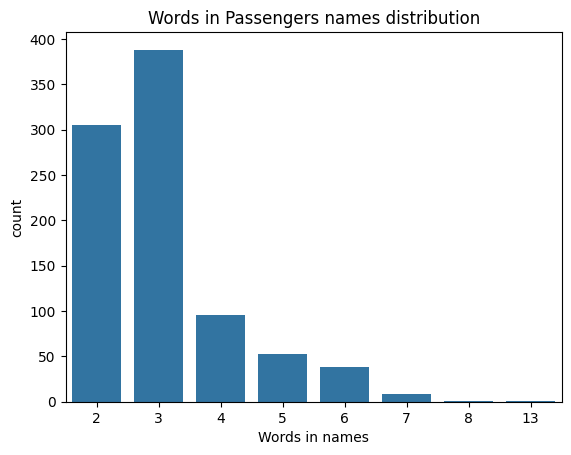

In [12]:
sns.countplot(titanic_data, x="Name")
plt.xlabel("Words in names")
plt.title("Words in Passengers names distribution")

Text(0.5, 1.0, 'Passangers age distribution')

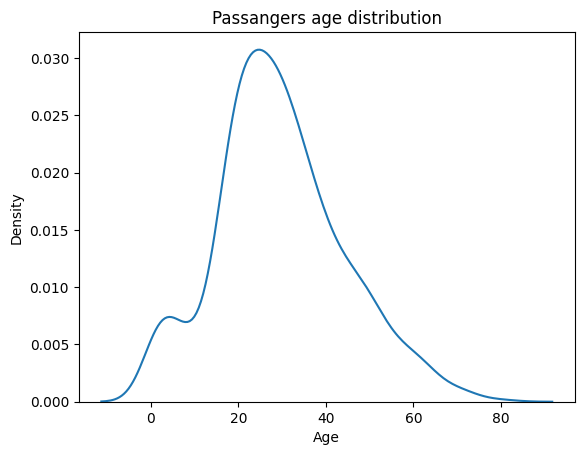

In [13]:
sns.kdeplot(titanic_data,x="Age")
plt.title("Passangers age distribution")

Text(0.5, 1.0, 'Passengers fare distribution')

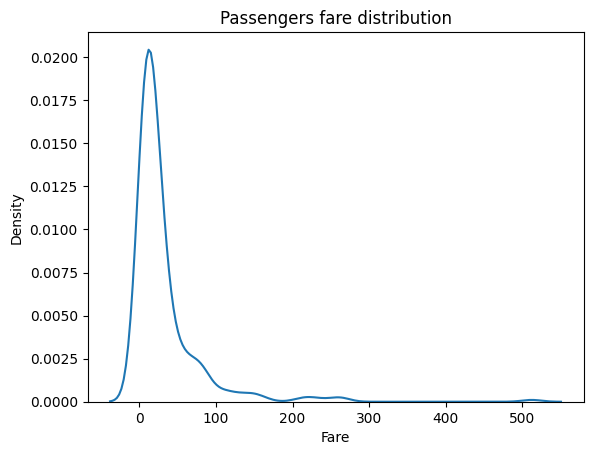

In [14]:
sns.kdeplot(titanic_data,x="Fare")
plt.title("Passengers fare distribution")

Text(0.5, 1.0, 'Pclass distribution')

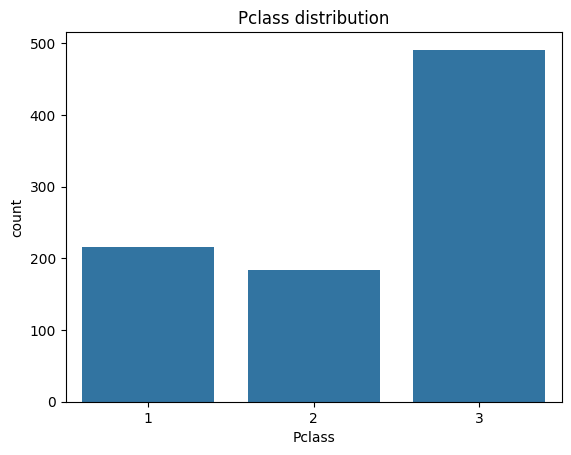

In [15]:
sns.countplot(titanic_data, x= "Pclass")
plt.title("Pclass distribution")

Text(0.5, 0, 'Parch / Siblings')

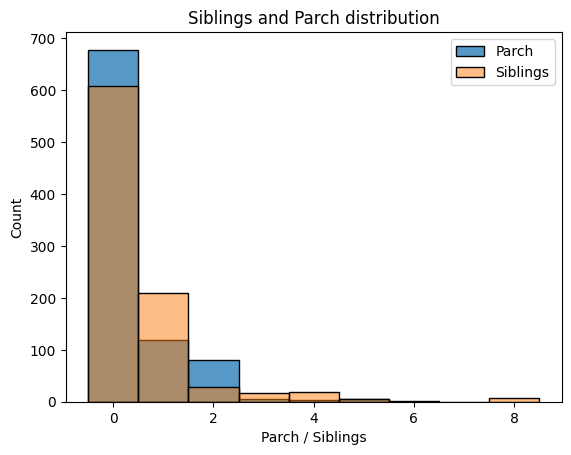

In [16]:
sns.histplot(titanic_data,x="Parch", label="Parch", discrete=True)
sns.histplot(titanic_data,x="SibSp", label ="Siblings", discrete=True, alpha = 0.5)

plt.legend()
plt.title("Siblings and Parch distribution")
plt.xlabel("Parch / Siblings")

# Creating Model
RandomForestRegressor was choosed for age prediction because of providing predictions by mean in groups

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [18]:
#Creating test dataset
titanic_test = pd.read_csv("../../data/test.csv")

#count number of words by spaces in names
name_words_count = titanic_test.Name.apply(lambda x: x.count(" "))
titanic_test["Name"] = name_words_count

#Encoding for sex (1 - male, 0 - female)
titanic_test["Sex"]= titanic_test.Sex.apply(lambda x: x == "male")

#drop tickets number and cabins from dataset
titanic_test = titanic_test.drop(["Ticket","Cabin"], axis=1)

In [19]:
#One hot encoding
titanic_data = pd.get_dummies(titanic_data, columns=["Embarked"])
titanic_test = pd.get_dummies(titanic_test, columns=["Embarked"])

#set indexes in dataframes
titanic_data = titanic_data.set_index("PassengerId")
titanic_test = titanic_test.set_index("PassengerId")

#Delete NA age from subsets
titanic_data =titanic_data[-titanic_data["Age"].isna()]
titanic_test = titanic_test[-titanic_test["Age"].isna()]

#Fill 2 NA Fare data
titanic_test["Fare"] = titanic_test.Fare.fillna(titanic_test.Fare.mean())

X_train = titanic_data.drop(["Age","Survived"], axis=1)
y_train = titanic_data["Age"]

X_test = titanic_test.drop("Age", axis=1)
y_test = titanic_test["Age"]

In [20]:
# Params grid function
def compute_grid(parameters):
    """Compute first raw search grid"""
    rgrs = RandomForestRegressor(random_state=42)

    search = GridSearchCV(rgrs,param_grid=parameters, n_jobs=-1, verbose=True)
    search.fit(X_train,y_train)
    return search

In [21]:
# print(compute_grid(parameters = {
#         "n_estimators":range(200,600,200),
#         "max_depth":range(25,100,25),
#         "min_samples_split": range(25,100,25),
#         "min_samples_leaf": range(25,100,25)
#     }).best_params_ )

#First grid result
parameters = {
    'max_depth': 25,
    'min_samples_leaf': 25,
    'min_samples_split': 25,
    'n_estimators': 400
}

# print(compute_grid(parameters = {
#         "n_estimators":range(300,450,50),
#         "max_depth":range(10,50,10),
#         "min_samples_split": range(10,50,10),
#         "min_samples_leaf": range(10,50,10),
#     }).best_params_ )

#Second grid result
parameters = {
    'max_depth': 20,
    'min_samples_leaf': 10,
    'min_samples_split': 40,
    'n_estimators': 400
    }

# print(compute_grid(parameters = {
#         "n_estimators":range(350,400,10),
#         "max_depth":range(10,20,5),
#         "min_samples_split": range(30,40,2),
#         "min_samples_leaf": range(2,10,2),
#     }).best_params_ )

#Third grid result
parameters = { 
    'max_depth': 10,
    'min_samples_leaf': 2,
    'min_samples_split': 30,
    'n_estimators': 380
    }

# print(compute_grid(parameters = {
#         "n_estimators":range(370,390,2),
#         "max_depth":range(2,14,2),
#         "min_samples_split": range(29,31),
#     }).best_params_ )

#Final choosed parameters
parameters = { 
    'max_depth': 6,
    'min_samples_leaf': 2,
    'min_samples_split': 29,
    'n_estimators': 388
    }

In [22]:
#Creating model
rgrs = RandomForestRegressor(random_state=42, **parameters)
rgrs.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, min_samples_split=29,
                      n_estimators=388, random_state=42)

## Features Interpretation

Text(0.5, 1.0, 'Feature importances')

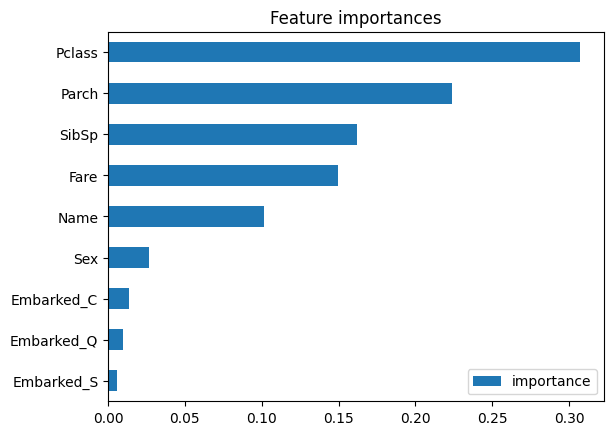

In [23]:
features = pd.DataFrame(rgrs.feature_importances_, index=X_train.columns, columns=['importance'])
features.sort_values("importance").plot(kind="barh")
plt.title("Feature importances")

## Errors visualization

In [24]:
# Prediction
y_pred = rgrs.predict(X_test)

# Mean error
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean absolute prediction error (MAE): {mae:.2f} years")
print(f"Mean absolute error median sample (MAE): {(abs(y_test - y_test.median())).mean():.2f} years")
print(f"Mean absolute error mean sample (MAE): {(abs(y_test - y_test.mean())).mean():.2f} years")

Mean absolute prediction error (MAE): 9.22 years
Mean absolute error median sample (MAE): 10.94 years
Mean absolute error mean sample (MAE): 11.17 years


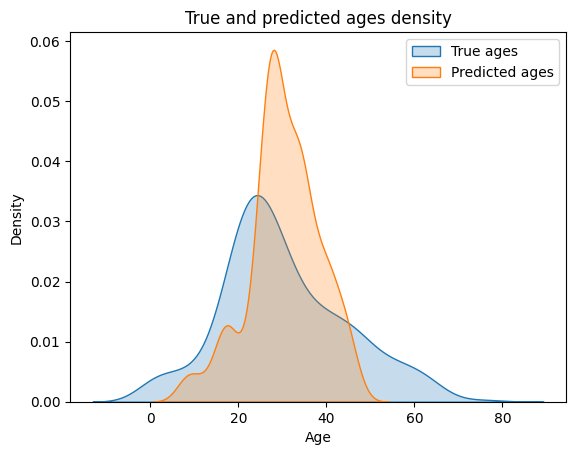

In [25]:
true_pred = pd.DataFrame({
    "True":y_test,
    "Predicted":y_pred,
    'Error': abs(y_test - y_pred)
})

sns.kdeplot(true_pred,x="True", label = "True ages", fill=True)
sns.kdeplot(true_pred,x="Predicted", label = "Predicted ages" , fill=True)

plt.title("True and predicted ages density")
plt.xlabel("Age")
plt.legend()

# Model saving
Save model for later use with joblib library

In [26]:
import joblib

In [30]:
# saving model in file
joblib.dump(rgrs, "../../job lib models/Age_RF_predictor.joblib")

['../../job lib models/Age_RF_predictor.joblib']

Created model can be used in other Jupyter notebook wuth library joblib.

Needed preprocessing is:

- Deleting NA's from data
- Name word count feature

- Dropping next rows:
    - PassangerID
    - Ticket number
    - Cabin
    - Surviving row

- Creating Embarked One-hot encoding

# Conclusion
Final random forest regressor provide good prediction potential and give better results otherwise mean or median edge (see MAE mean differences). It can be used in titanic prediction model for filling ages NA.

Ml model was saved as Age_RF_predictor.job_lib and can be used in other Jupiter Notebooks

Most important in Random Forest features are:
- Pclass
- Parch
- SibSp
- Fare
- Name

This was my first kaggle notebook! Thanks for reading